# Computing lag features

[Feature Engineering for Time Series Forecasting](https://www.trainindata.com/p/feature-engineering-for-forecasting)

In this notebook we show how we can use Pandas to compute lag features. We then show how to compute lag features using Feature-engine.

We will work with a monthly retail sales dataset (found [here](https://raw.githubusercontent.com/facebook/prophet/master/examples/example_retail_sales.csv)).

For instructions on how to download, prepare, and store the dataset, refer to notebook number 1, in the folder "01-Datasets" from this repo.

## Data Set Synopsis

The timeseries is collected between January 1992 and May 2016.

It consists of a single series of monthly values representing sales volumes. 

# Resources

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_context("talk")

# Load data

In [2]:
# Load retail sales dataset 
df = pd.read_csv(
    "../Datasets/example_retail_sales.csv",
    parse_dates=["ds"],
    index_col=["ds"],
)

In [3]:
df.head()

,y
ds,
1992-01-01,146376
1992-02-01,147079
1992-03-01,159336
1992-04-01,163669
1992-05-01,170068


Text(0.5, 0, 'Time')

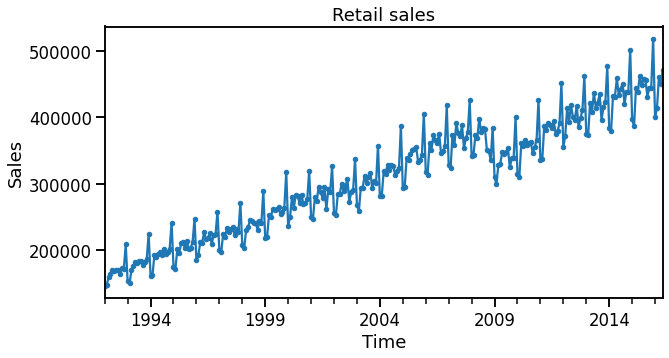

In [4]:
fig, ax = plt.subplots(figsize=[10, 5])
ax = df.plot(y="y", marker=".", figsize=[10, 5], legend=None, ax=ax)
ax.set_title('Retail sales')
ax.set_ylabel('Sales')
ax.set_xlabel('Time')

# Compute lag of a column in Pandas

The `shift` method of a dataframe allows us to create lag features


In [5]:
df_ = df.copy()  # Create a copy to preserve the original dataframe
                 # for later use.

lag = 2  # As the time series is uniformly spaced by months we can
         # specify the lag in terms of the number of periods. In
         # this case the period is in unit of months.

df_[f"y_lag_{lag}"] = df_["y"].shift(periods=lag)
df_.head()

,y,y_lag_2
ds,,
1992-01-01,146376,NaN
1992-02-01,147079,NaN
1992-03-01,159336,146376.0
1992-04-01,163669,147079.0
1992-05-01,170068,159336.0


You can also specify the `freq` of the time index so that the correct time duration is lagged rather than simply the number of rows.

In [6]:
df_ = df.copy()  # Create a copy to preserve the original dataframe
                 # for later use

lag = 2  # As the time series is uniformly spaced by months we can
         # specify the lag in terms of the number of periods. In
         # this case the period is in unit of months.

df_[f"y_lag_{lag}"] = df_["y"].shift(periods=lag, freq="MS")
df_.head()

,y,y_lag_2
ds,,
1992-01-01,146376,NaN
1992-02-01,147079,NaN
1992-03-01,159336,146376.0
1992-04-01,163669,147079.0
1992-05-01,170068,159336.0


You can also specify the `freq` of the time index and append the number of periods to shift by at the start of the string, omitting the `period` argument entirely.

In [7]:
df_ = df.copy()  # Create a copy to preserve the original dataframe
                 # for later use

freq = "2MS"
df_[f"y_lag_{freq}"] = df_["y"].shift(freq=freq)
df_.head()

,y,y_lag_2MS
ds,,
1992-01-01,146376,NaN
1992-02-01,147079,NaN
1992-03-01,159336,146376.0
1992-04-01,163669,147079.0
1992-05-01,170068,159336.0


# Compute lag features using Feature-engine

In [8]:
from feature_engine.timeseries.forecasting import LagFeatures

Feature engine can compute multiple lags at the same time.

In [9]:
lag_transformer = LagFeatures(variables=["y"], freq=["1MS", "2MS", "3MS"])
lag_transformer.fit_transform(df)

,y,y_lag_1MS,y_lag_2MS,y_lag_3MS
ds,,,,
1992-01-01,146376,NaN,NaN,NaN
1992-02-01,147079,146376.0,NaN,NaN
1992-03-01,159336,147079.0,146376.0,NaN
1992-04-01,163669,159336.0,147079.0,146376.0
1992-05-01,170068,163669.0,159336.0,147079.0
...,...,...,...,...
2016-01-01,400928,518253.0,444507.0,444959.0
2016-02-01,413554,400928.0,518253.0,444507.0
2016-03-01,460093,413554.0,400928.0,518253.0


# Compute lag of multiple time series using Pandas


Let's look at an example where we have multiple time-series defined over different time periods (e.g., sales volumes for different countries, but the sales period may start at different times in different countries).

We create a toy dataset for this example.

In [10]:
time1 = pd.date_range(start="2000-01-01", end="2000-01-06")
y1 = np.random.rand(len(time1))
time2 = pd.date_range(start="2000-01-03", end="2000-01-10")
y2 = np.random.rand(len(time2))

It is typical to find the data represented as follows:

In [11]:
df_1 = pd.DataFrame({"ds": time1, "y": y1, "country": "UK"})
df_2 = pd.DataFrame({"ds": time2, "y": y2, "country": "France"})
df = pd.concat([df_1, df_2])
df.sort_values(by=["country", "ds"]) # Sort to ensure the time series groups 
                                     # are contiguous. 
df.set_index("ds", inplace=True)
df

,y,country
ds,,
2000-01-01,0.870109,UK
2000-01-02,0.496001,UK
2000-01-03,0.708407,UK
2000-01-04,0.313938,UK
2000-01-05,0.111558,UK
2000-01-06,0.883858,UK
2000-01-03,0.289137,France
2000-01-04,0.338983,France
2000-01-05,0.284201,France


This representation means that multiple time-series at different time stamps are stored in the same columns `y` and `ds`.

Let's look at potential mistakes in trying to use `shift` for this dataframe

In [12]:
# Mistake in using shift for this dataset
df["y_lag"] = df["y"].shift(periods=1)
df

,y,country,y_lag
ds,,,
2000-01-01,0.870109,UK,NaN
2000-01-02,0.496001,UK,0.870109
2000-01-03,0.708407,UK,0.496001
2000-01-04,0.313938,UK,0.708407
2000-01-05,0.111558,UK,0.313938
2000-01-06,0.883858,UK,0.111558
2000-01-03,0.289137,France,0.883858
2000-01-04,0.338983,France,0.289137
2000-01-05,0.284201,France,0.338983


This is wrong as you can see the values from one timeseries have been shifted into the other.

To get the correct result we want to set the index to be a datetime type and specify the frequency that we want to shift the index by and re-join to the original dataframe.

In [13]:
# Drop the wrong version of the lag
df = df.drop(columns=["y_lag"])

In [14]:
# Shift the timeseries index to get the lagged versions
df_shift = df.loc[:, ["country", "y"]].shift(periods=5, freq="D")
df_shift

,country,y
ds,,
2000-01-06,UK,0.870109
2000-01-07,UK,0.496001
2000-01-08,UK,0.708407
2000-01-09,UK,0.313938
2000-01-10,UK,0.111558
2000-01-11,UK,0.883858
2000-01-08,France,0.289137
2000-01-09,France,0.338983
2000-01-10,France,0.284201


In [15]:
# Join back to the original dataframe
df.merge(df_shift, on=["ds", "country"], how="left", suffixes=("", "_lag"))

,y,country,y_lag
ds,,,
2000-01-01,0.870109,UK,NaN
2000-01-02,0.496001,UK,NaN
2000-01-03,0.708407,UK,NaN
2000-01-04,0.313938,UK,NaN
2000-01-05,0.111558,UK,NaN
2000-01-06,0.883858,UK,0.870109
2000-01-03,0.289137,France,NaN
2000-01-04,0.338983,France,NaN
2000-01-05,0.284201,France,NaN


Note: This assumed the time series were evenly spaced in time!